Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 105.9009
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 25.0019
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 21.0942
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 18.7412
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 23.3893
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 20.3420
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 18.6674
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 17.9375
Epoch 9/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 20.0927
Epoch 10/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 17.5264
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MAE: 4.248041152954102
RMSE: 6.998444520606548
R2 Score: 0.5073885321617126
Mean Error: 0.90159432915806
Std Dev of Error: 6.94012604216387


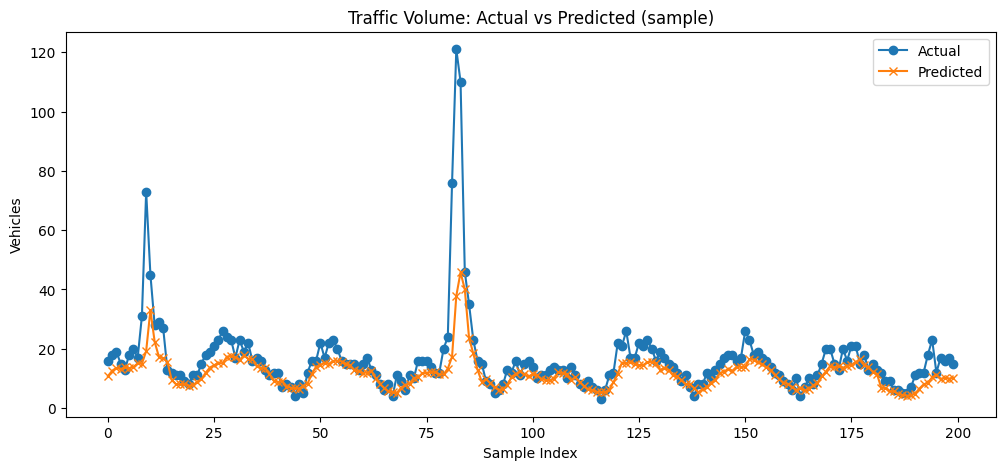

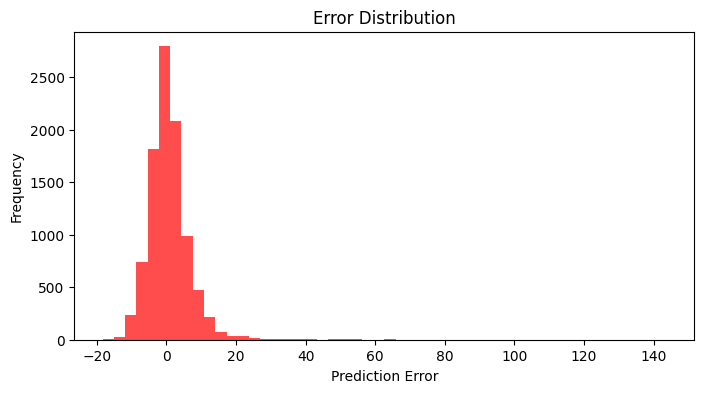

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("traffic.csv")

# Convert DateTime to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Feature engineering
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Features and target
X = df[['Junction', 'hour', 'dayofweek', 'month', 'is_weekend']]
y = df['Vehicles']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------- XGBoost -----------------
xgb_model = xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# ----------------- LSTM -----------------
# Prepare time-series data
sequence_length = 10
train_series = y_train.values.reshape(-1, 1)
test_series = y_test.values.reshape(-1, 1)
train_gen = TimeseriesGenerator(train_series, train_series, length=sequence_length, batch_size=32)
test_gen = TimeseriesGenerator(test_series, test_series, length=sequence_length, batch_size=32)

# Build LSTM
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(train_gen, epochs=10, verbose=1)

# Predict with LSTM
lstm_pred = lstm_model.predict(test_gen).flatten()

# Align lengths for ensemble
min_len = min(len(xgb_pred), len(lstm_pred))
xgb_pred, lstm_pred, y_true = xgb_pred[-min_len:], lstm_pred[-min_len:], y_test.values[-min_len:]

# ----------------- Ensemble -----------------
final_pred = (0.6 * xgb_pred) + (0.4 * lstm_pred)

# ----------------- Evaluation -----------------
mae = mean_absolute_error(y_true, final_pred)
rmse = np.sqrt(mean_squared_error(y_true, final_pred))
r2 = r2_score(y_true, final_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2 Score:", r2)

# ----------------- Error Analysis -----------------
errors = y_true - final_pred

print("Mean Error:", np.mean(errors))
print("Std Dev of Error:", np.std(errors))

# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_true[:200], label='Actual', marker='o')
plt.plot(final_pred[:200], label='Predicted', marker='x')
plt.title('Traffic Volume: Actual vs Predicted (sample)')
plt.xlabel('Sample Index')
plt.ylabel('Vehicles')
plt.legend()
plt.show()

# Plot error distribution
plt.figure(figsize=(8,4))
plt.hist(errors, bins=50, color='red', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()